Import modules

In [1]:
import os
import numpy as np
from pathlib import Path
import random

from one.api import ONE

from utils.ibl_utils import (
    prepare_data,
    bin_spiking_data,
    list_brain_regions,
    select_brain_regions,
    load_video_index,
    load_keypoints,
    load_video,
    resize_video,
    load_keypoints
)
from utils.utils import (
    set_seed,
    get_args,
)

from tqdm import tqdm

set_seed(42)

/home/yl6624/.conda/envs/mv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


seed set to 42


Set Paths information

In [2]:
# ---------------
# PREPROCESS DATA
# ---------------
one = ONE(
    base_url="https://openalyx.internationalbrainlab.org",
    password="international", 
    silent=True,
    cache_dir='../../data/ibl'
)

params = {
    "interval_len": 2, 
    "binsize": 0.02, 
    "single_region": False,
    "align_time": 'stimOn_times', 
    "time_window": (-.5, 1.5), 
    "fr_thresh": 0.5
}

beh_names = [
    "choice", 
    "reward", 
    "block",
    "wheel-speed", 
    "whisker-motion-energy", 
]

N_WORKERS = 4

DYNAMIC_VARS = list(filter(lambda x: x not in ["choice", "reward", "block"], beh_names))

ENCODING_TEST_EIDS_PATH = "../../data/encoding_test_eids.txt"
IDXS_DIR = Path("../../data/idxs")

with open(ENCODING_TEST_EIDS_PATH, "r") as f:
    eids = f.read().splitlines()

ANCHOR_CAMERA = "left"

# Random select 100 integers between 0 to 119, make sure there are no duplicates
RANDOM_VID_IDX = random.sample(range(120), 100)
# sort the random indices
RANDOM_VID_IDX.sort()

OUTPUT_DIR = Path("../../data/encoding/ibl-mouse-separate")

avail_views = ['left', 'right']

print(f"Number of encoding sessions: {len(eids)}")
print(eids)

Number of encoding sessions: 10
['d23a44ef-1402-4ed7-97f5-47e9a7a504d9', 'db4df448-e449-4a6f-a0e7-288711e7a75a', '3638d102-e8b6-4230-8742-e548cd87a949', '4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b', '03d9a098-07bf-4765-88b7-85f8d8f620cc', '0841d188-8ef2-4f20-9828-76a94d5343a4', '9b528ad0-4599-4a55-9148-96cc1d93fb24', 'f140a2ec-fd49-4814-994a-fe3476f14e66', '687017d4-c9fc-458f-a7d5-0979fe1a7470', 'd04feec7-d0b7-4f35-af89-0232dd975bf0']


Get encoding sessions

In [3]:
for eid_idx, eid in enumerate(eids):
    neural_dict, behave_dict, meta_data, trials_data, _ = prepare_data(
                one, eid, n_workers=N_WORKERS
    )
    regions, beryl_reg = list_brain_regions(neural_dict, **params)
    region_cluster_ids = select_brain_regions(neural_dict, beryl_reg, regions, **params)
    binned_spikes, clusters_used_in_bins, intervals = bin_spiking_data(
        region_cluster_ids,
        neural_dict,
        trials_df=trials_data['trials_df'],
        n_workers=1,
        **params
    )
    # Keep responsive neurons
    mean_fr = binned_spikes.sum(1).mean(0) / params["interval_len"]
    keep_unit_idxs = np.argwhere(mean_fr > 1/params["fr_thresh"]).flatten()
    binned_spikes = binned_spikes[..., keep_unit_idxs]

    # load video index list
    anchor_video_index_list, url = load_video_index(one, eid, ANCHOR_CAMERA, intervals)
    # load all view urls
    view_url_dict = {view: load_video_index(one, eid, view, only_url=True) for view in avail_views}

    # load all view indices
    view_idxs_dict = {}
    for view in avail_views:
        if view == ANCHOR_CAMERA:
            view_idxs_dict[view] = anchor_video_index_list
            continue
        # open the indices file which end with .npy
        idxs_path = IDXS_DIR / f"_ibl_{view}.indices.{eid}.npy"
        view_idxs = np.load(idxs_path)
        view_idxs_list = []
        for i in range(len(intervals)):
            _interval_idx = anchor_video_index_list[i]
            view_interval_idxs = view_idxs[_interval_idx].tolist()
            # select only the random video indices
            view_idxs_list.append(view_interval_idxs)
        view_idxs_dict[view] = view_idxs_list

    # process each trial
    for trial_idx in tqdm(range(len(intervals)), desc=f"Processing trial for session {eid_idx+1}/{len(eids)}"):
        # trial spike
        spike = binned_spikes[trial_idx]
        video_views, kp_views = {}, {}
        for view in avail_views:
            trial_video = load_video(
                index=view_idxs_dict[view][trial_idx],
                url=view_url_dict[view]
            )
        
            # select only the random video indices
            trial_video = trial_video[RANDOM_VID_IDX]
            _, h, w = trial_video.shape
            h = w = 224
            trial_video = resize_video(
                video=trial_video,
                height=h,
                width=w
            )
            # add view-video to dict
            video_views[view] = trial_video
            # deal with keypoints
            kps = load_keypoints(one, eid, view)
            trial_kps ={}
            for key, kp in kps.items():
                trial_kps[key] = kp[view_idxs_dict[view][trial_idx]].to_numpy()
                trial_kps[key] = trial_kps[key][RANDOM_VID_IDX]
                # check of there is any nan value in the keypoint
                assert not np.isnan(trial_kps[key]).any(), f'Nan value in keypoint {key}'
            kp_views[view] = trial_kps
        data = {
            'video': video_views,
            'keypoints': kp_views,
            'spike': spike,
            'meta': {
                'eid': eid,
                'trial_idx': trial_idx,
                'interval': intervals[trial_idx],
            }
        }
        save_path = os.path.join(OUTPUT_DIR, eid, f"{trial_idx}.npy")
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        np.save(save_path, data)
        break
    break

Merge 2 probes for session eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9


  0%|          | 0/3 [00:00<?, ?it/s]/home/yl6624/.conda/envs/mv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-30"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/yl6624/.conda/envs/mv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Use spikes from brain regions:  ['CA1' 'DCO' 'DG' 'Eth' 'IP' 'LP' 'PARN' 'PO' 'SIM' 'SPVI' 'VISam' 'VPLpc'
 'root' 'y']


100%|██████████| 410/410 [00:56<00:00,  7.32it/s]


get meta info
The video length = 218896
The video fps = 60
The video width = 1280
The video height = 1024
The video duration = 1:00:48.266667
The video size = 5712382476


Processing trial for session 1/10:   0%|          | 0/410 [00:00<?, ?it/s]/home/yl6624/.conda/envs/mv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/yl6624/.conda/envs/mv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
Processing trial for session 1/10:   0%|          | 0/410 [01:32<?, ?it/s]


In [4]:
# get all .npy files in the OUTPUT_DIR
npy_files = list(OUTPUT_DIR.rglob("*.npy"))
print(f"Number of .npy files in {OUTPUT_DIR}: {len(npy_files)}")
# load one npy file to check
data = np.load(npy_files[0], allow_pickle=True).item()
print(data.keys())

Number of .npy files in ../../data/encoding/ibl-mouse-separate: 63
dict_keys(['video', 'keypoints', 'spike', 'meta'])


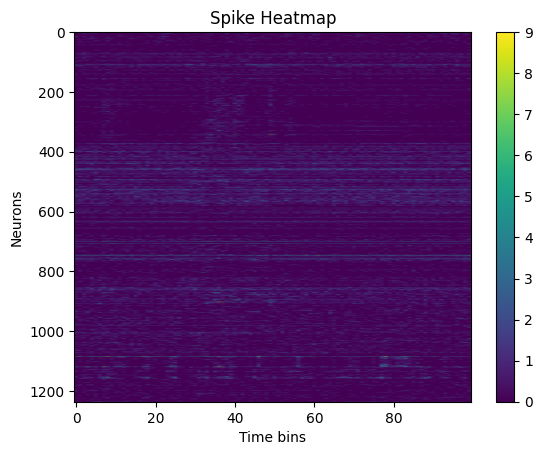

In [5]:
spike = data['spike']
import matplotlib.pyplot as plt
# spike is a 2D array, imshow it
plt.imshow(spike.T, aspect='auto')
plt.colorbar()
plt.xlabel('Time bins')
plt.ylabel('Neurons')
plt.title('Spike Heatmap')
plt.show()

0 255


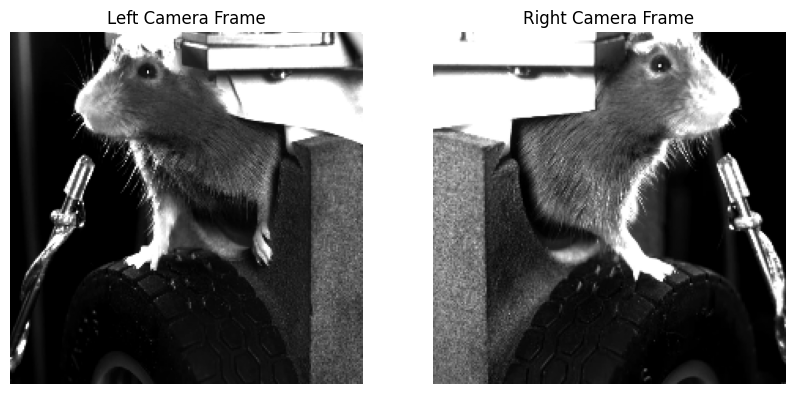

In [6]:
left_frame = data['video']['left'][8]
right_frame = data['video']['right'][8]

print(data['video']['left'].min(), data['video']['left'].max())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(left_frame, cmap='gray')
plt.title('Left Camera Frame')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(right_frame, cmap='gray')
plt.title('Right Camera Frame')
plt.axis('off')
plt.show()

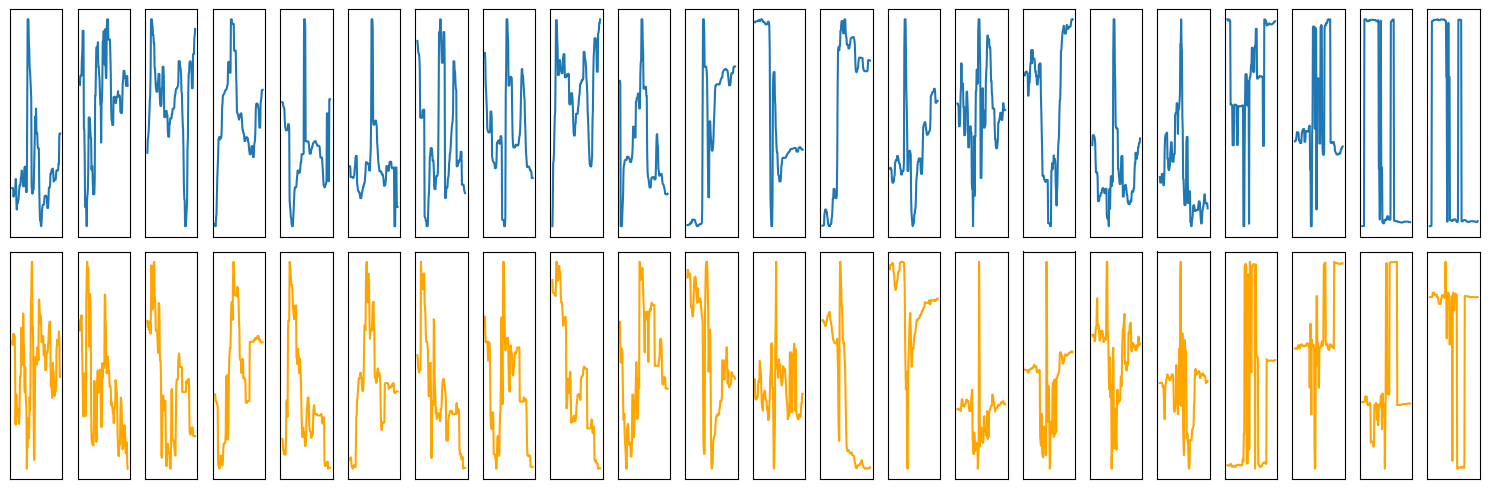

In [7]:
# left keypoints

left_kps = data['keypoints']['left']
right_kps = data['keypoints']['right']

concat_left_kps = []

for key in left_kps.keys():
    concat_left_kps.append(left_kps[key])
concat_left_kps = np.stack(concat_left_kps, axis=0)  # shape (num_keypoints, Time)

concat_right_kps = []

for key in right_kps.keys():
    concat_right_kps.append(right_kps[key])
concat_right_kps = np.stack(concat_right_kps, axis=0)  # shape (num_keypoints, Time)

# plot left/right keypoints, their num_keypoints should be the same
num_keypoints = concat_left_kps.shape[0]
time = np.arange(concat_left_kps.shape[1])
plt.figure(figsize=(15, 5))
for i in range(num_keypoints):
    plt.subplot(2, num_keypoints, i+1)
    plt.plot(time, concat_left_kps[i], label=f'Left {list(left_kps.keys())[i]}')
    # plt.xlabel('Time')
    # plt.ylabel('Position')
    # plt.legend()
    
    plt.subplot(2, num_keypoints, i+1+num_keypoints)
    plt.plot(time, concat_right_kps[i], label=f'Right {list(right_kps.keys())[i]}', color='orange')
    # plt.xlabel('Time')
    # plt.ylabel('Position')
    # plt.legend()
# turn of the x ticks and y ticks
for ax in plt.gcf().axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()